# Import Modules

In [1]:
import pandas as pd
import numpy as np

from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from itertools import zip_longest 
from copy import copy

# Setup Plot General Configurations

In [2]:
# Pandas
pd.set_option('display.max_rows', 100)

# Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'font.size': 18})


# Definition of 4D Heatmap Plot

In [18]:
def heatmap_4d(volume: pd.DataFrame, probabilities: pd.DataFrame
              ,xlabel: str="xlabel", ylabel: str="ylabel", figsize: tuple=(20, 30)):
    
    #srcs: https://blogs.oii.ox.ac.uk/bright/2014/08/12/point-size-legends-in-matplotlib-and-basemap-plots/
    #      https://stackoverflow.com/questions/54545758/create-equal-aspect-square-plot-with-multiple-axes-when-data-limits-are-differ/54555334#54555334

    
    # 1. Figure Object Instantiation
    fig, heatmap = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(heatmap)
    legend = divider.append_axes("bottom", size=1, pad=1)

    # 2. Heatmap    
    # 2.a. Get Labels
    ylabels = volume.index
    xlabels = volume.columns.values
    x, y = np.meshgrid(np.arange(xlabels.shape[0]), np.arange(ylabels.shape[0]))

    # 2.b. Get Values
    volume = volume.values
    probabilities = probabilities.values
    
    # 2.c. Calculate List of Radii, Make Circles, and Plot
    radii_list = volume/volume.max()/2
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(radii_list.flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=probabilities.flatten(), cmap='coolwarm', edgecolors='k', linewidth=2)
    heatmap.add_collection(col)

    heatmap.set(xticks=np.arange(xlabels.shape[0]), yticks=np.arange(ylabels.shape[0])
               ,xticklabels=xlabels, yticklabels=ylabels)

    heatmap.set_xticks(np.arange(xlabels.shape[0]+1)-0.5, minor=True)
    heatmap.set_yticks(np.arange(ylabels.shape[0]+1)-0.5, minor=True)
    heatmap.grid(which='major', linestyle=":")
    heatmap.set_ylabel(ylabel)
    heatmap.set_xlabel(xlabel)

    heatmap.axes.set_aspect('equal')

    # 3. Legend
    # 3.a. Setup Ticks
    leg_xticks = np.arange(xlabels.shape[0])
    leg_yticks = range(2)
    
    # 3.c. Setup Tick Labels
    min_volume = min([volume for volume in volume.flatten() if volume>0])
    leg_xticklabels = np.linspace(min_volume, max(volume.flatten()), len(leg_xticks), dtype=int)
    leg_yticklabels = [0, 1]
    
    # 3.d. Calculate Radii List Statistical Summary
    radii_list_summary = list(np.percentile(radii_list.flatten(), [25, 50, 75]))
    iqr = max(radii_list_summary) - min(radii_list_summary)
    leg_radii_list = copy(radii_list_summary)
    leg_radii_list.append(max(min(radii_list_summary) - 1.5*iqr, min(radii_list.flat)))
    leg_radii_list.append(min(max(radii_list_summary) + 1.5*iqr, max(radii_list.flat)))
    leg_radii_list = sorted(leg_radii_list)
    
    # 3.e. Calculate Volume List Statistical Summary
    vol_summary = list(np.percentile(volume.flatten(), [25, 50, 75]))
    iqr = max(vol_summary) - min(vol_summary)
    leg_vol_stats = copy(vol_summary)
    leg_vol_stats.append(max(min(vol_summary) - 1.5*iqr, min(volume.flat)))
    leg_vol_stats.append(min(max(vol_summary) + 1.5*iqr, max(volume.flat)))
    leg_vol_stats = sorted(leg_vol_stats)
    
    # 3.e. Calculate What Volumes in the Statistical Summary is Closest to the the x tick labels
    leg_vol_idx = dict(zip_longest(leg_xticklabels, leg_xticks))
    leg_vol_list = [leg_xticklabels[(np.abs(leg_xticklabels - volume)).argmin()] for volume in leg_vol_stats]
    
    # 3.f. Get Position for the Circles, and Plot THem
    leg_circle_pos = [leg_vol_idx[item] for item in leg_vol_list]
    leg_circle_pos = sorted(leg_circle_pos)
    legend_circles = [plt.Circle((i, 0.5), radius=r) for r, i in zip(leg_radii_list, leg_circle_pos)]
    legend_col = PatchCollection(legend_circles, edgecolors='k', linewidth=2)
    legend.add_collection(legend_col)

    # Adjust x labels so that only the plotted circles will have an x tick
    xlabels = [label if label in leg_vol_list else "" for label in leg_xticklabels]
    legend.set(xticks=leg_xticks, yticks=leg_yticks, xticklabels=xlabels, yticklabels=[])
    legend.set_xticks(np.arange(len(leg_xticklabels)+2)-0.5, minor=True)
    legend.set_yticks(np.arange(len(leg_yticklabels)+1)-0.5, minor=True)

    # 3.g. Format Plot
    legend.set_xlabel("Volume")
    legend.axes.set_aspect('equal')
    legend.spines['right'].set_visible(False)
    legend.spines['left'].set_visible(False)
    legend.spines['top'].set_visible(False)
    legend.spines['bottom'].set_visible(False)
    legend.tick_params(axis=u'both', which=u'both',length=0)

    # 4. Setup Heatmap Colorbar
    axins = inset_axes(heatmap, width="1%", height="100%", loc='upper right', bbox_to_anchor=(0.05, 0., 1, 1), bbox_transform=heatmap.transAxes, borderpad=1)
    fig.colorbar(col, cax=axins)
    
    fig.tight_layout()
    
    return heatmap, legend

# Example

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


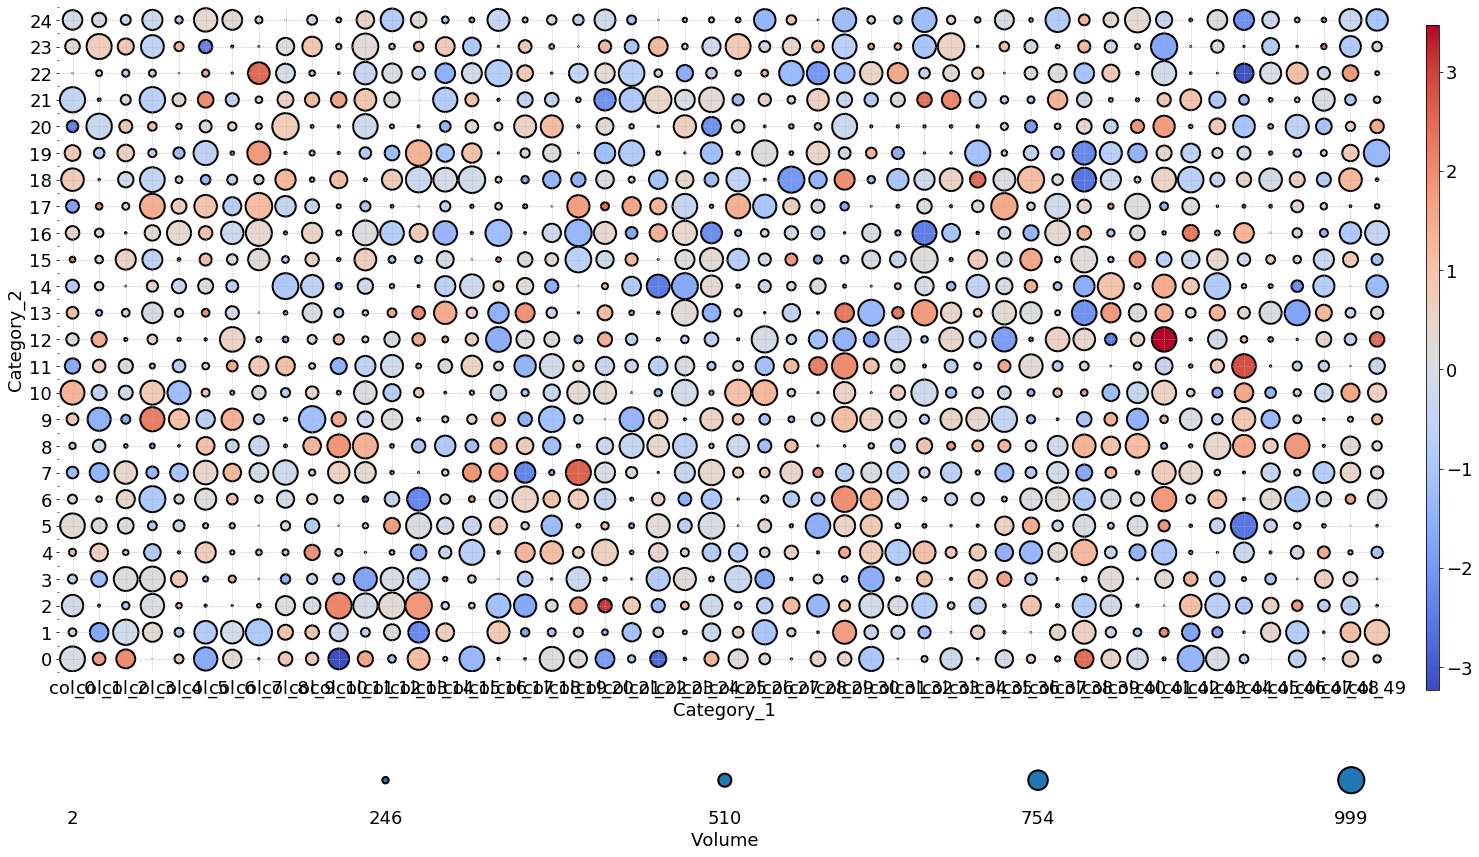

In [19]:
nrows = 25
ncols = 50

volume = pd.DataFrame(np.random.randint(0, 1000, size=(nrows, ncols)), columns=[f"col_{i}" for i in range(ncols)])
probabilities = pd.DataFrame(np.random.randn(nrows, ncols), columns=[f"col_{i}" for i in range(ncols)])

heatmap, legend = heatmap_4d(volume, probabilities, xlabel="Category_1", ylabel="Category_2")
